In [4]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import warnings
from pyramid.arima import auto_arima

warnings.filterwarnings('ignore')
plt.style.use('bmh')
%matplotlib inline

In [2]:
data = pd.read_csv('../raw data/new/btc_hourly.csv')

In [3]:
data.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2019-02-01T00:00:00.0000000Z,2019-02-01T01:00:00.0000000Z,2019-02-01T00:00:00.0000000Z,2019-02-01T00:59:58.6240000Z,3413.69,4801.89,3302.01111,3410.62,16176.11220,5239
1,2019-02-01T01:00:00.0000000Z,2019-02-01T02:00:00.0000000Z,2019-02-01T01:00:00.0000000Z,2019-02-01T01:59:58.0000000Z,3496.00,5575.47,2197.12000,3387.20,17787.21738,8078
2,2019-02-01T02:00:00.0000000Z,2019-02-01T03:00:00.0000000Z,2019-02-01T02:00:00.0000000Z,2019-02-01T02:59:59.1200000Z,3476.00,4055.97,2191.11000,3388.21,14935.60829,4863
3,2019-02-01T03:00:00.0000000Z,2019-02-01T04:00:00.0000000Z,2019-02-01T03:00:00.0000000Z,2019-02-01T03:59:59.4890000Z,3480.70,5519.47,2175.06000,3395.34,15145.67548,4217
4,2019-02-01T04:00:00.0000000Z,2019-02-01T05:00:00.0000000Z,2019-02-01T04:00:00.0000000Z,2019-02-01T04:59:57.0000000Z,3394.48,4055.93,3302.00001,3388.19,14572.54123,3339


In [4]:
# data.tail()

In [5]:
data = data[['time_period_start', 'price_close']]

In [6]:
# data

In [7]:
data['time_period_start'] = pd.to_datetime(data['time_period_start'])

In [8]:
data = data.set_index('time_period_start')

In [9]:
data = data.resample('H').mean()

In [10]:
np.where(np.isnan(data))

(array([], dtype=int64), array([], dtype=int64))

In [11]:
data.index

DatetimeIndex(['2019-02-01 00:00:00', '2019-02-01 01:00:00',
               '2019-02-01 02:00:00', '2019-02-01 03:00:00',
               '2019-02-01 04:00:00', '2019-02-01 05:00:00',
               '2019-02-01 06:00:00', '2019-02-01 07:00:00',
               '2019-02-01 08:00:00', '2019-02-01 09:00:00',
               ...
               '2019-04-30 14:00:00', '2019-04-30 15:00:00',
               '2019-04-30 16:00:00', '2019-04-30 17:00:00',
               '2019-04-30 18:00:00', '2019-04-30 19:00:00',
               '2019-04-30 20:00:00', '2019-04-30 21:00:00',
               '2019-04-30 22:00:00', '2019-04-30 23:00:00'],
              dtype='datetime64[ns]', name='time_period_start', length=2136, freq='H')

In [12]:
y = data['price_close']

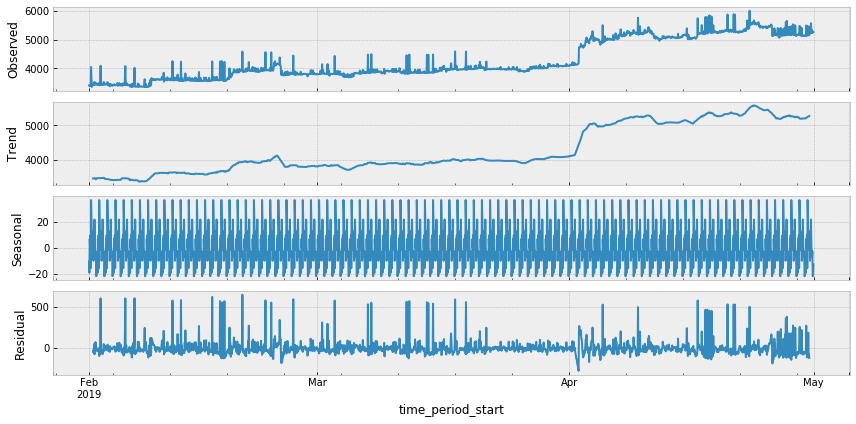

In [13]:
rcParams['figure.figsize'] = 12, 6

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.resample('D').mean()
    rolstd = timeseries.resample('D').std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
    print()
    #Perform Ljung-Box test:
    print('Results of Ljung-Box Test:')
    lbtest = acorr_ljungbox(timeseries, lags=5)
    for i in range(5):
        print('Largest Lag Included:{} Test Statistic={}  p-value={}'.format(i, lbtest[0][i], lbtest[1][i]))

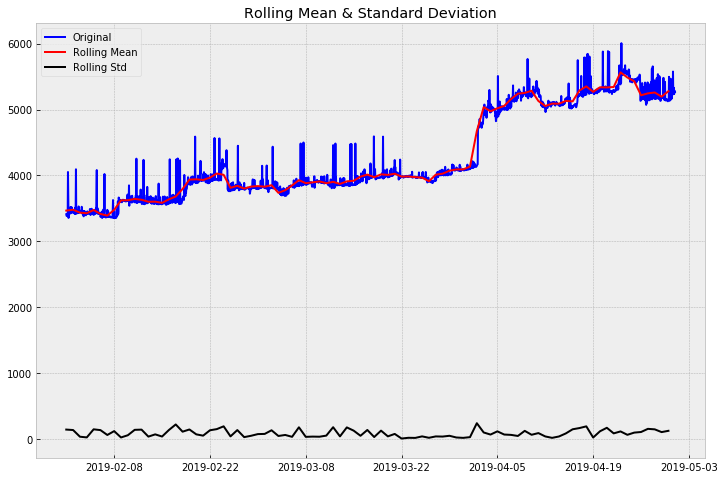

Results of Dickey-Fuller Test:
Test Statistic                   -0.537570
p-value                           0.884474
#Lags Used                       12.000000
Number of Observations Used    2123.000000
Critical Value (1%)              -3.433434
Critical Value (5%)              -2.862902
Critical Value (10%)             -2.567495
dtype: float64

Results of Ljung-Box Test:
Largest Lag Included:0 Test Statistic=2056.117048158934  p-value=0.0
Largest Lag Included:1 Test Statistic=4107.774258239584  p-value=0.0
Largest Lag Included:2 Test Statistic=6152.278370830012  p-value=0.0
Largest Lag Included:3 Test Statistic=8192.98165343944  p-value=0.0
Largest Lag Included:4 Test Statistic=10231.250569131367  p-value=0.0


In [15]:
test_stationarity(y)

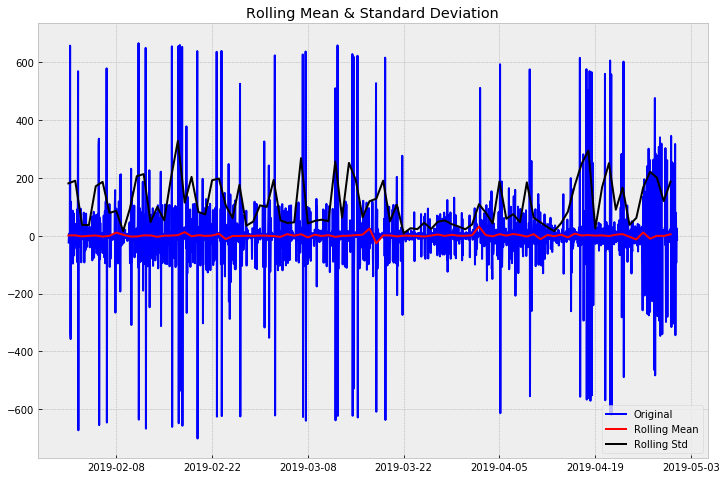

Results of Dickey-Fuller Test:
Test Statistic                  -18.936234
p-value                           0.000000
#Lags Used                       11.000000
Number of Observations Used    2123.000000
Critical Value (1%)              -3.433434
Critical Value (5%)              -2.862902
Critical Value (10%)             -2.567495
dtype: float64

Results of Ljung-Box Test:
Largest Lag Included:0 Test Statistic=512.8200780090851  p-value=1.5440086227873578e-113
Largest Lag Included:1 Test Statistic=513.5047914981176  p-value=3.1178219536852862e-112
Largest Lag Included:2 Test Statistic=514.4181232354152  p-value=3.5806661594673155e-111
Largest Lag Included:3 Test Statistic=514.6992015061719  p-value=4.432985060176479e-110
Largest Lag Included:4 Test Statistic=517.0136911800306  p-value=1.696261752146549e-109


In [16]:
test_stationarity(y.diff(1).dropna())

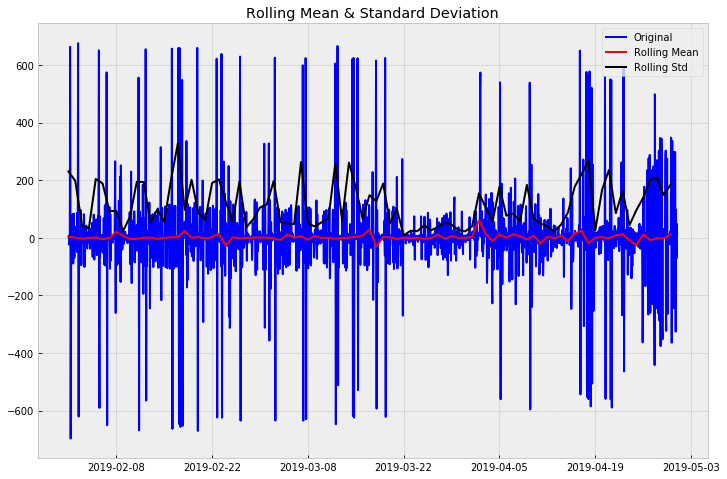

Results of Dickey-Fuller Test:
Test Statistic                -9.447625e+00
p-value                        4.708898e-16
#Lags Used                     2.600000e+01
Number of Observations Used    2.107000e+03
Critical Value (1%)           -3.433457e+00
Critical Value (5%)           -2.862913e+00
Critical Value (10%)          -2.567501e+00
dtype: float64

Results of Ljung-Box Test:
Largest Lag Included:0 Test Statistic=3.021340533285694  p-value=0.0821755135886731
Largest Lag Included:1 Test Statistic=465.4861144513775  p-value=8.336323232106567e-102
Largest Lag Included:2 Test Statistic=467.98992232164795  p-value=4.1234708630101387e-101
Largest Lag Included:3 Test Statistic=468.2257086323056  p-value=4.981448007118691e-100
Largest Lag Included:4 Test Statistic=472.815095382262  p-value=5.876449741469722e-100


In [17]:
test_stationarity(y.diff(2).dropna())

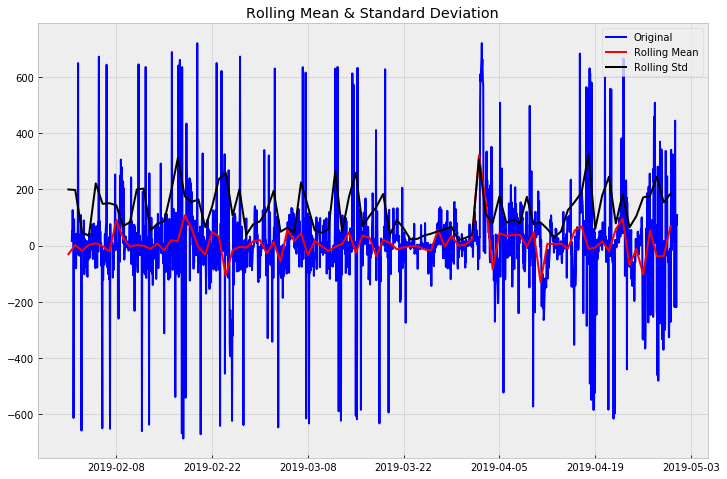

Results of Dickey-Fuller Test:
Test Statistic                -8.319175e+00
p-value                        3.611436e-13
#Lags Used                     2.600000e+01
Number of Observations Used    2.097000e+03
Critical Value (1%)           -3.433472e+00
Critical Value (5%)           -2.862919e+00
Critical Value (10%)          -2.567504e+00
dtype: float64

Results of Ljung-Box Test:
Largest Lag Included:0 Test Statistic=99.83816152862047  p-value=1.6537291003128515e-23
Largest Lag Included:1 Test Statistic=197.0930981268187  p-value=1.5913933215023161e-43
Largest Lag Included:2 Test Statistic=273.59055609510693  p-value=5.159825112072974e-59
Largest Lag Included:3 Test Statistic=334.94155923923284  p-value=3.1252813245572513e-71
Largest Lag Included:4 Test Statistic=398.35387103728186  p-value=6.714982641174048e-84


In [18]:
test_stationarity(y.diff(12).dropna())

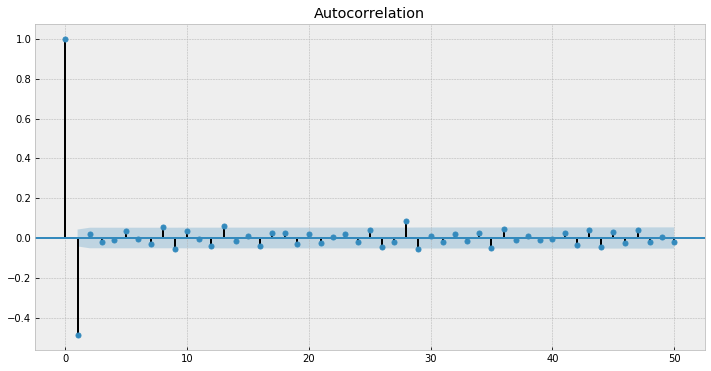

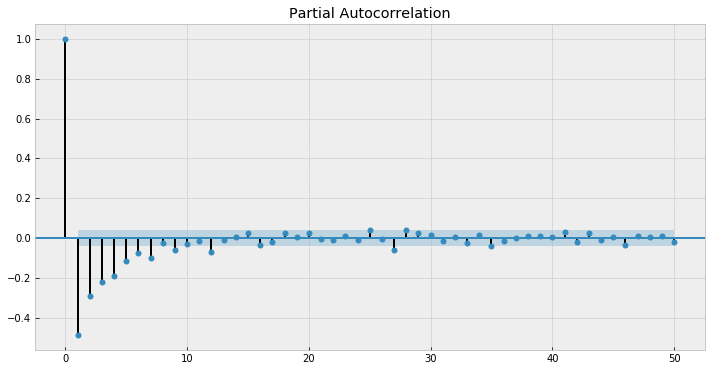

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
 
acf = plot_acf(y.diff(1).dropna(), lags=50)
pacf = plot_pacf(y.diff(1).dropna(), lags=50)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7833      0.009    -83.108      0.000      -0.802      -0.765
sigma2      1.079e+04    105.071    102.716      0.000    1.06e+04     1.1e+04
25866.020963105133


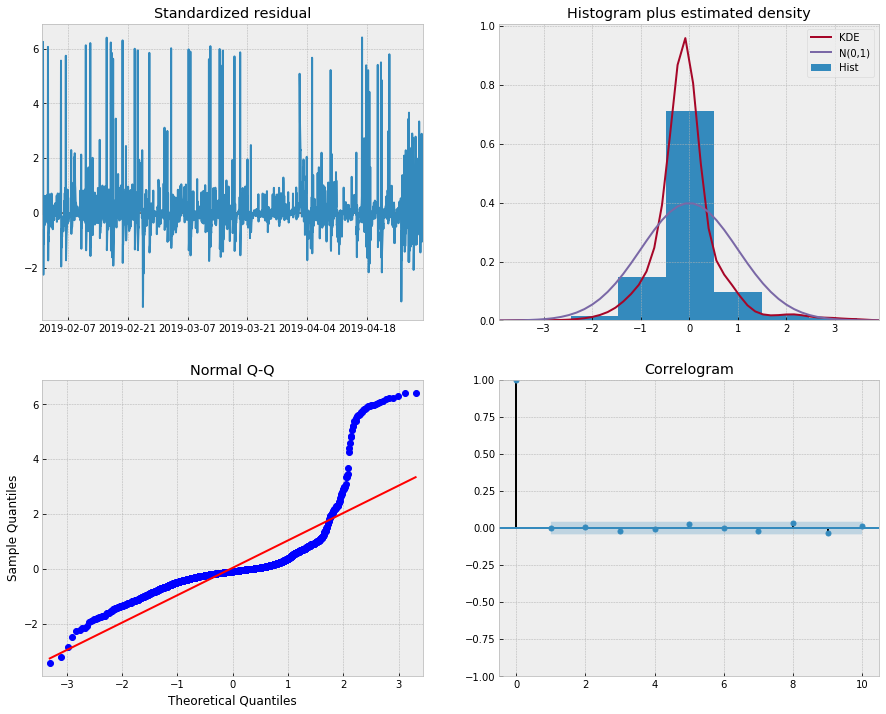

In [20]:
mod_baseline = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order = (0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_baseline = mod_baseline.fit()

print(results_baseline.summary().tables[1])
print(results_baseline.aic)
b = results_baseline.plot_diagnostics(figsize=(15, 12))

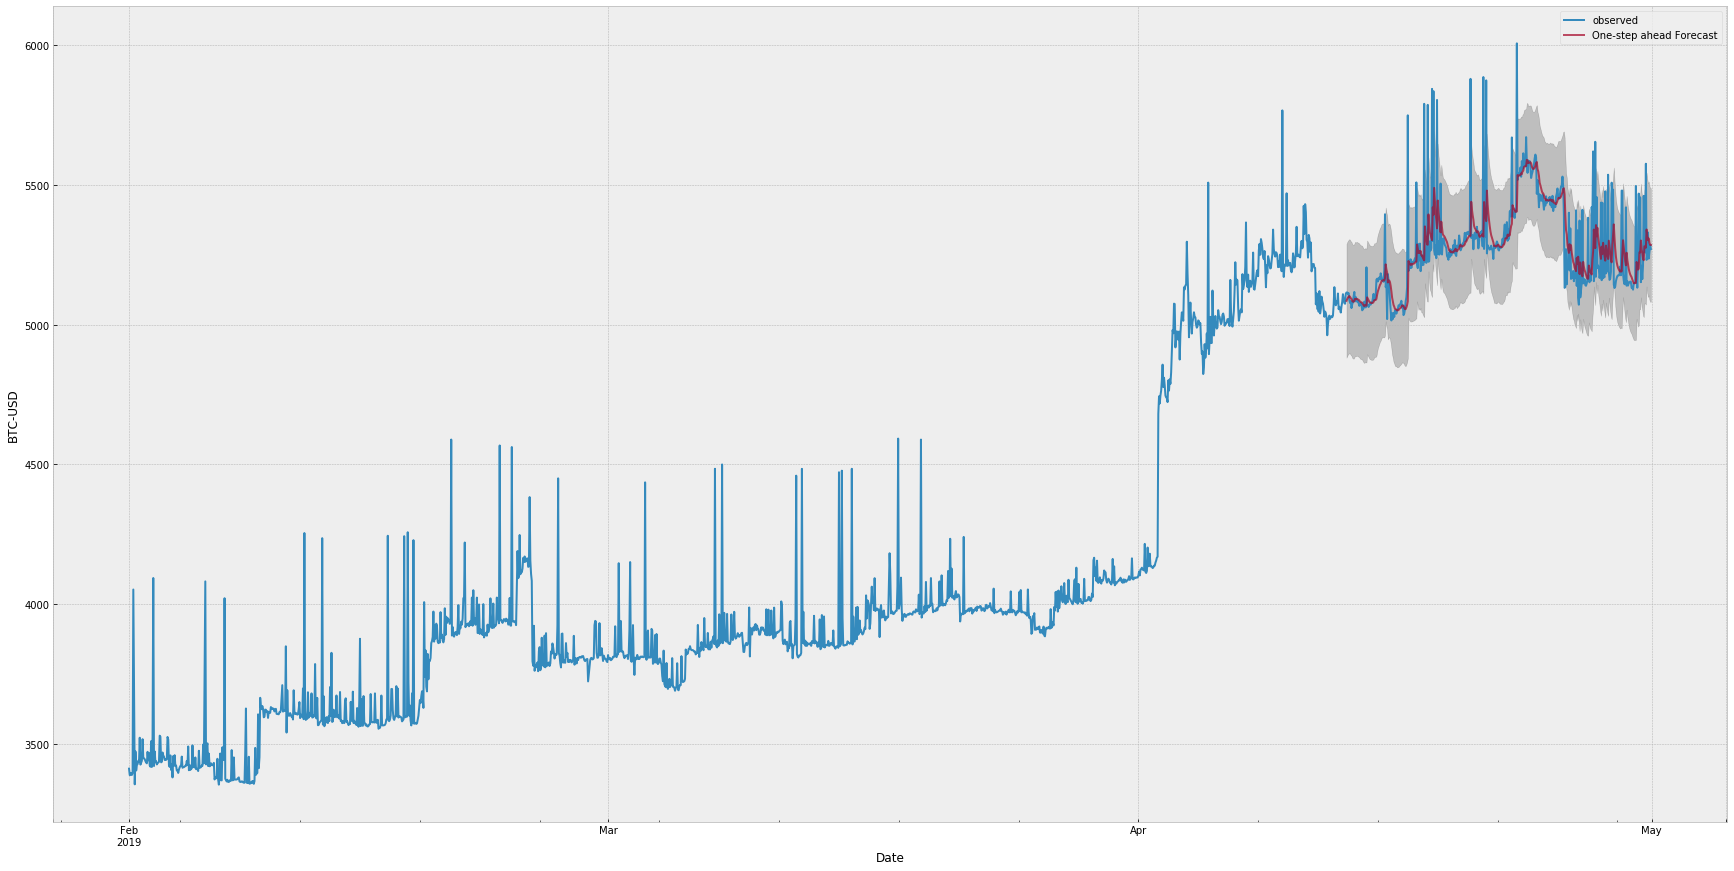

In [21]:
pred = results_baseline.get_prediction(start=y.index[int(len(y)*0.8)], end=y.index[-1], dynamic=False)
pred_ci = pred.conf_int()

ax = y.plot(label='observed', figsize=(30, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('BTC-USD')
plt.legend()

In [22]:
y_forecasted = pred.predicted_mean
y_truth = y[int(len(y)*0.8):]
y_train = y[:int(len(y)*0.8)]

# MSE
mse = ((y_truth - y_forecasted) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

# OSR2
OSR2 = 1 - np.sum((y_truth - y_forecasted) ** 2)/np.sum((y_truth - np.average(y_truth)) ** 2)
print('The out-of-sample R2 of our model is {}'.format(round(OSR2, 4)))

The Mean Squared Error of our forecasts is 14982.1013
The out-of-sample R2 of our model is 0.4958


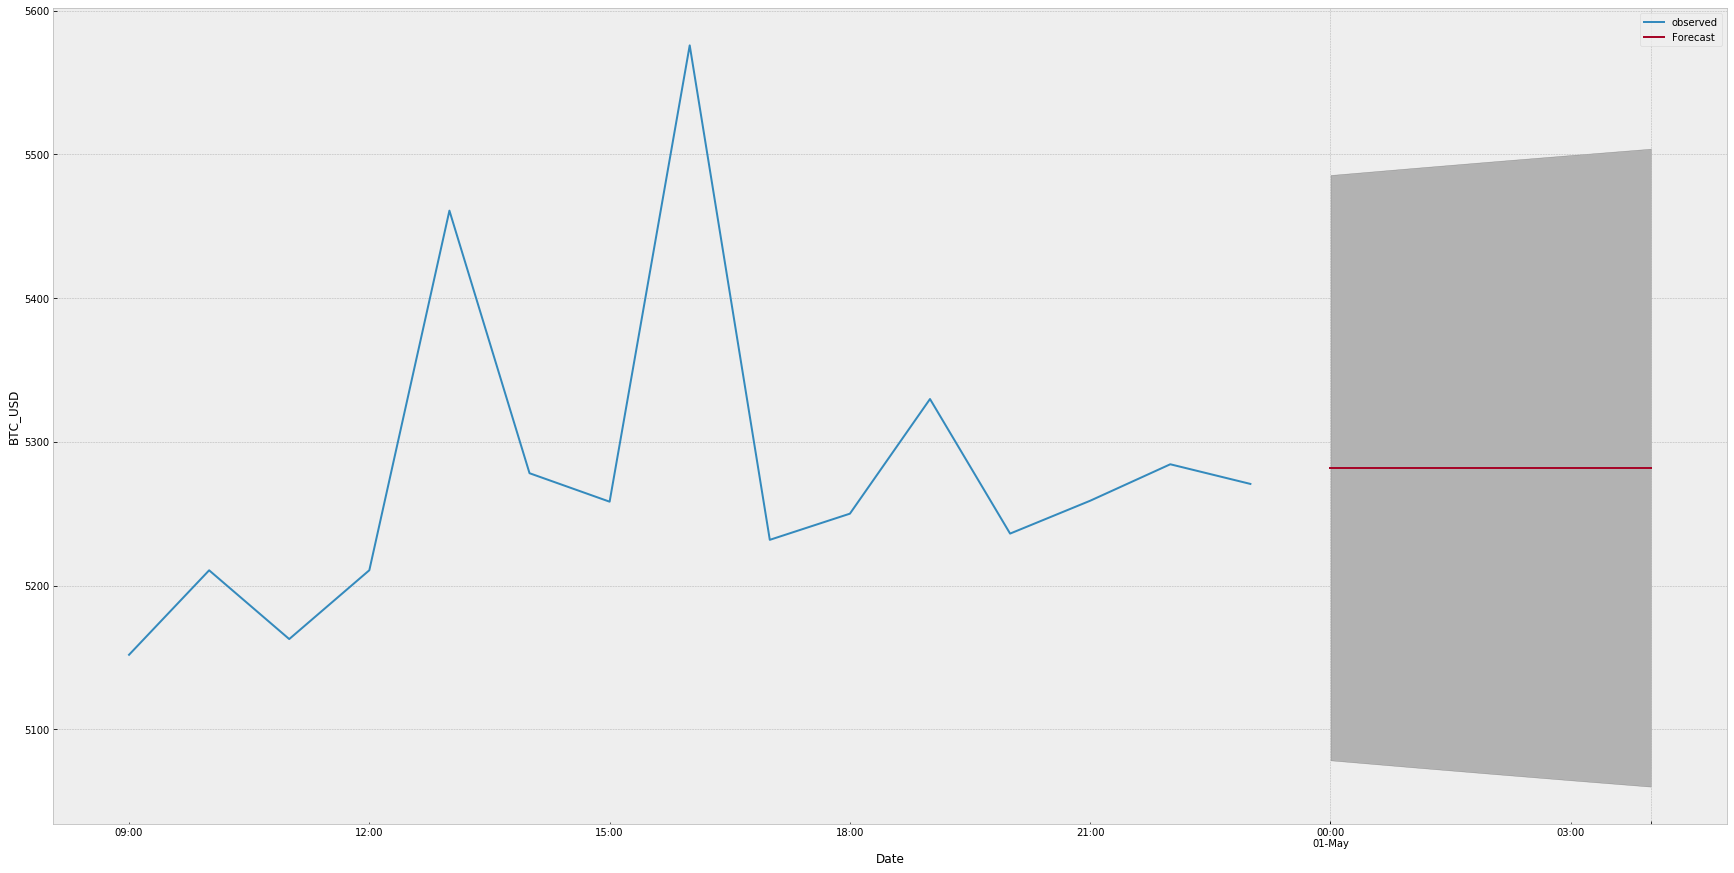

In [23]:
# Forcast the future
pred_uc = results_baseline.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()

ax = y[-15:].plot(label='observed', figsize=(30, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('BTC_USD')

plt.legend()

### Build an Advanced Model by Grid Search

In [24]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [25]:
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                           order = param,
                                           seasonal_order = param_seasonal,
                                           enforce_stationarity = False,
                                           enforce_invertibility = False)
            
            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)

        except:
            continue

print('Finished...')

AIC_list = AIC_list.dropna()
m = np.amin(AIC_list['AIC'].values) # Find the minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find the index number of the lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:41811.59122599356
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:40049.47257699698
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:36337.45029478618
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:27353.99990878321
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:26869.10395514087
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:26705.610098930734
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:29289.495058104992
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:27096.73250923776
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:26588.398222441578
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:27362.306607114828
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:27003.141305884397
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:26840.179286212464
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:26928.189953198747
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:26871.103938612625
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:26704.207384710167
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:28084.340606473732
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:26822.111718761014
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:26590.15325084239

ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:25594.41688767157
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:25407.631647508308
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:28002.153328459055
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:26338.156115618367
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:25424.35366572447
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:25576.160677051266
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:25569.34646945229
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:25536.054260670273
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:25973.790524174616
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:25452.18211611574
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:25405.73565430723
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:27142.997014054527
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:25898.02931786971
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:25916.497347857076
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:29216.23759788303
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:29028.825515875746
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:28874.89258049634
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:30600.020745830272


ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:26101.093378439953
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:25872.972248804137
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:25687.82601040494
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:25554.377105874744
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:27102.30017533543
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:25607.81556522935
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:25430.113797919603
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:29186.517903476015
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:26933.649759262764
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:25433.950586869876
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:25709.832862609346
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:25689.386355986757
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:25556.463493762898
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:26408.48049339953
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:25608.050667707208
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:25692.60862936912
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:27932.516957504573
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:26302.5355127146

ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:26866.785753092252
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:26045.680886755865
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:25942.0573376967
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:28421.375037147947
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:26782.656619853522
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:27272.615654928497
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:25986.85380033889
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:25981.25528475962
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:26036.091802197465
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:26394.65717234272
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:25869.15138747956
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:25876.501344963053
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:27570.535189522623
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:26321.77402944418
ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:27830.883152797698
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:25853.11563412682
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:25789.376745019512
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:25651.39452227545
A

ARIMA(2, 1, 0)x(2, 2, 1, 12)12 - AIC:26105.62996828211
ARIMA(2, 1, 0)x(2, 2, 2, 12)12 - AIC:25831.23804994786
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:25869.530104689395
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:25688.324556610984
ARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:25555.537312629218
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:27164.675483527135
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:25607.681273838265
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:25429.722105100485
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:29212.67773761294
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:26918.674499662604
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:26708.603730540293
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:25688.371412071778
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:25690.313741054157
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:25548.762508540716
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:26425.301105455714
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:25607.82231772365
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:25421.55157729656
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:27909.5809378817

### Min_AIC_list ### 
param                 (0, 1, 2)
param_seasonal    (2, 1, 2, 12)
AIC                     25405.7
Name: 158, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7868      0.015    -53.686      0.000      -0.816      -0.758
ma.L2          0.0082      0.017      0.485      0.627      -0.025       0.041
ar.S.L12      -0.6967      0.129     -5.389      0.000      -0.950      -0.443
ar.S.L24      -0.0418      0.023     -1.794      0.073      -0.087       0.004
ma.S.L12       0.4738      0.285      1.664      0.096      -0.084       1.032
ma.S.L24      -1.4696      0.281     -5.233      0.000      -2.020      -0.919
sigma2      4814.9917   1830.002      2.631      0.009    1228.255    8401.729


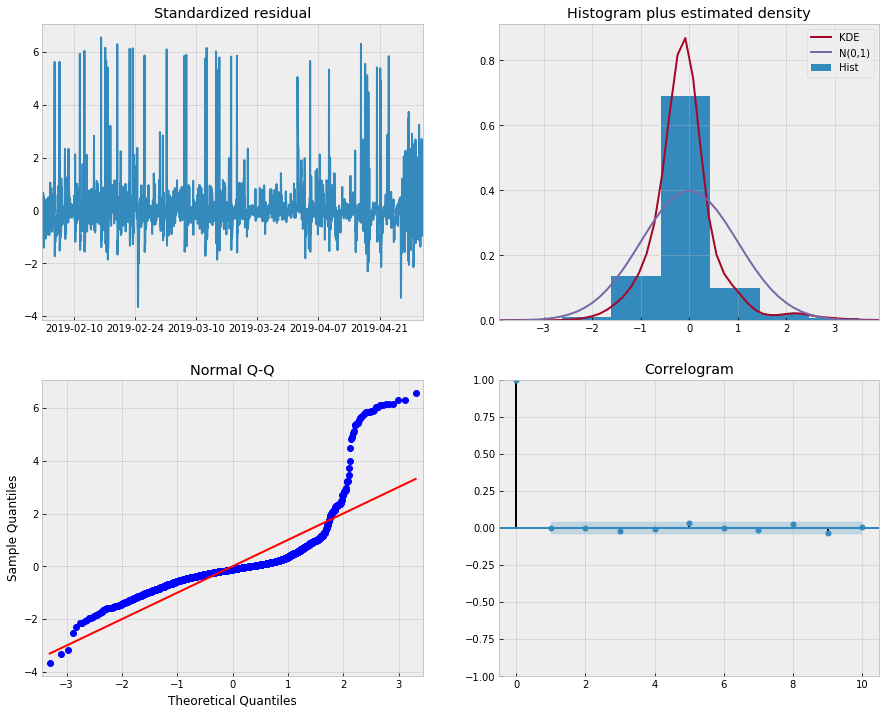

In [26]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=Min_AIC_list['param'],
                                seasonal_order=Min_AIC_list['param_seasonal'],
                                enforce_stationarity=False,
                                 enforce_invertibility=False)
results = mod.fit()

print("### Min_AIC_list ### \n{}".format(Min_AIC_list))

print(results.summary().tables[1])
dia = results.plot_diagnostics(figsize=(15, 12))

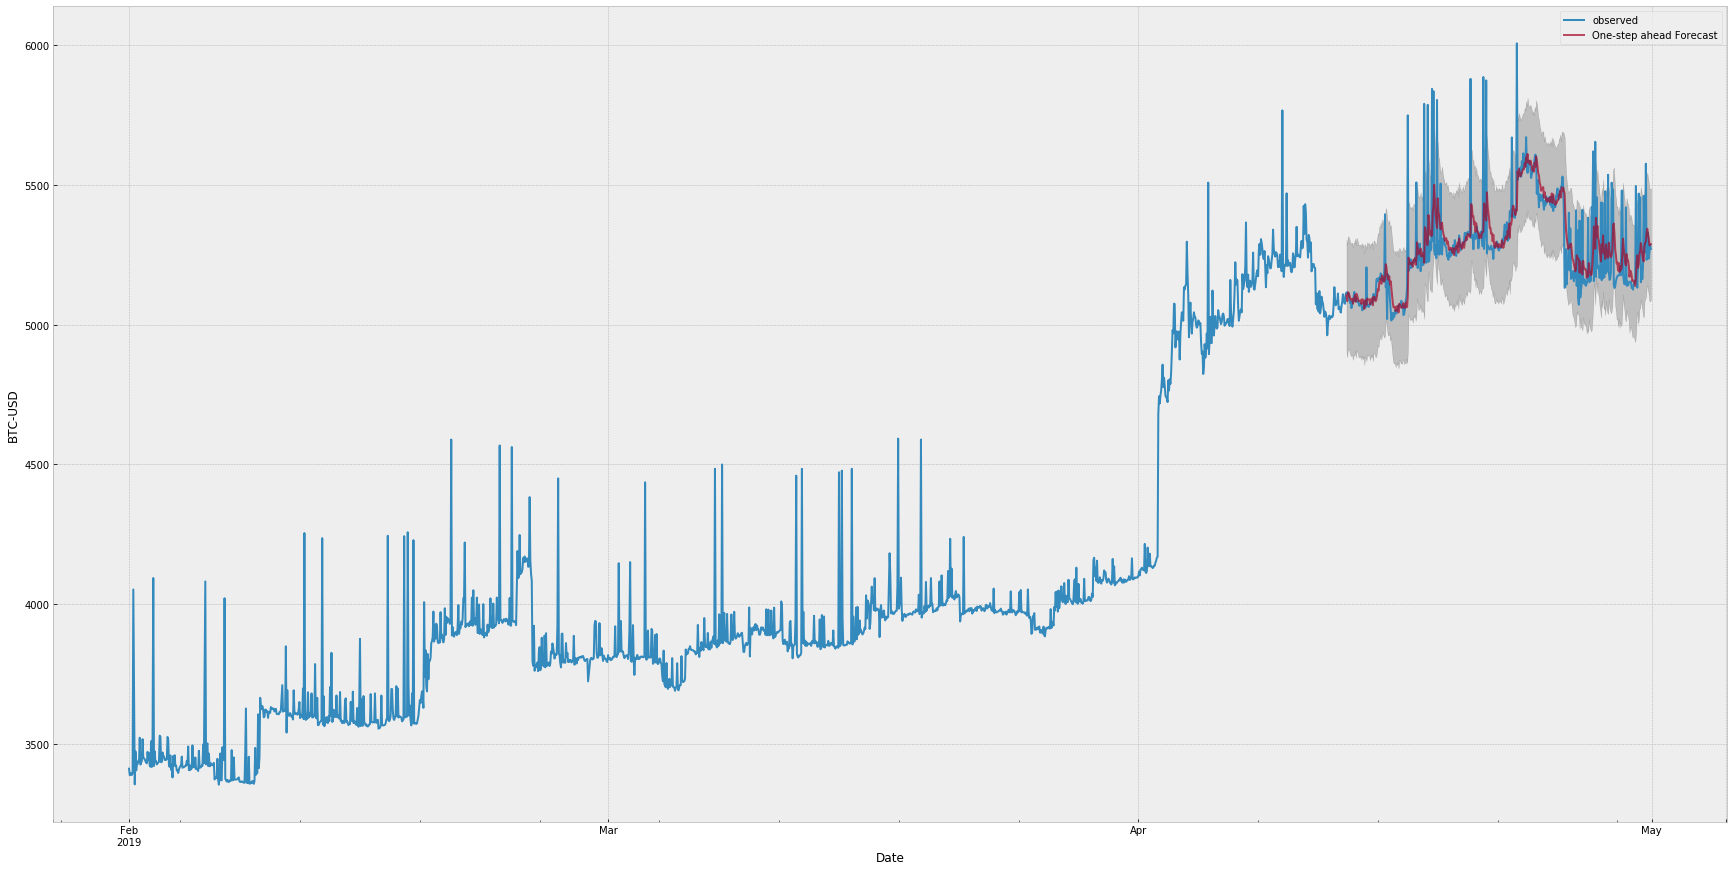

In [27]:
pred = results.get_prediction(start=y.index[int(len(y)*0.8)], end=y.index[-1], dynamic=False)
pred_ci = pred.conf_int()

ax = y.plot(label='observed', figsize=(30, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('BTC-USD')
plt.legend()

In [29]:
y_forecasted = pred.predicted_mean
y_truth = y[int(len(y)*0.8):]
y_train = y[:int(len(y)*0.8)]

# MSE
mse = ((y_truth - y_forecasted) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

# OSR2
OSR2 = 1 - np.sum((y_truth - y_forecasted) ** 2)/np.sum((y_truth - np.average(y_truth)) ** 2)
print('The out-of-sample R2 of our model is {}'.format(round(OSR2, 4)))

The Mean Squared Error of our forecasts is 14760.6954
The out-of-sample R2 of our model is 0.5033


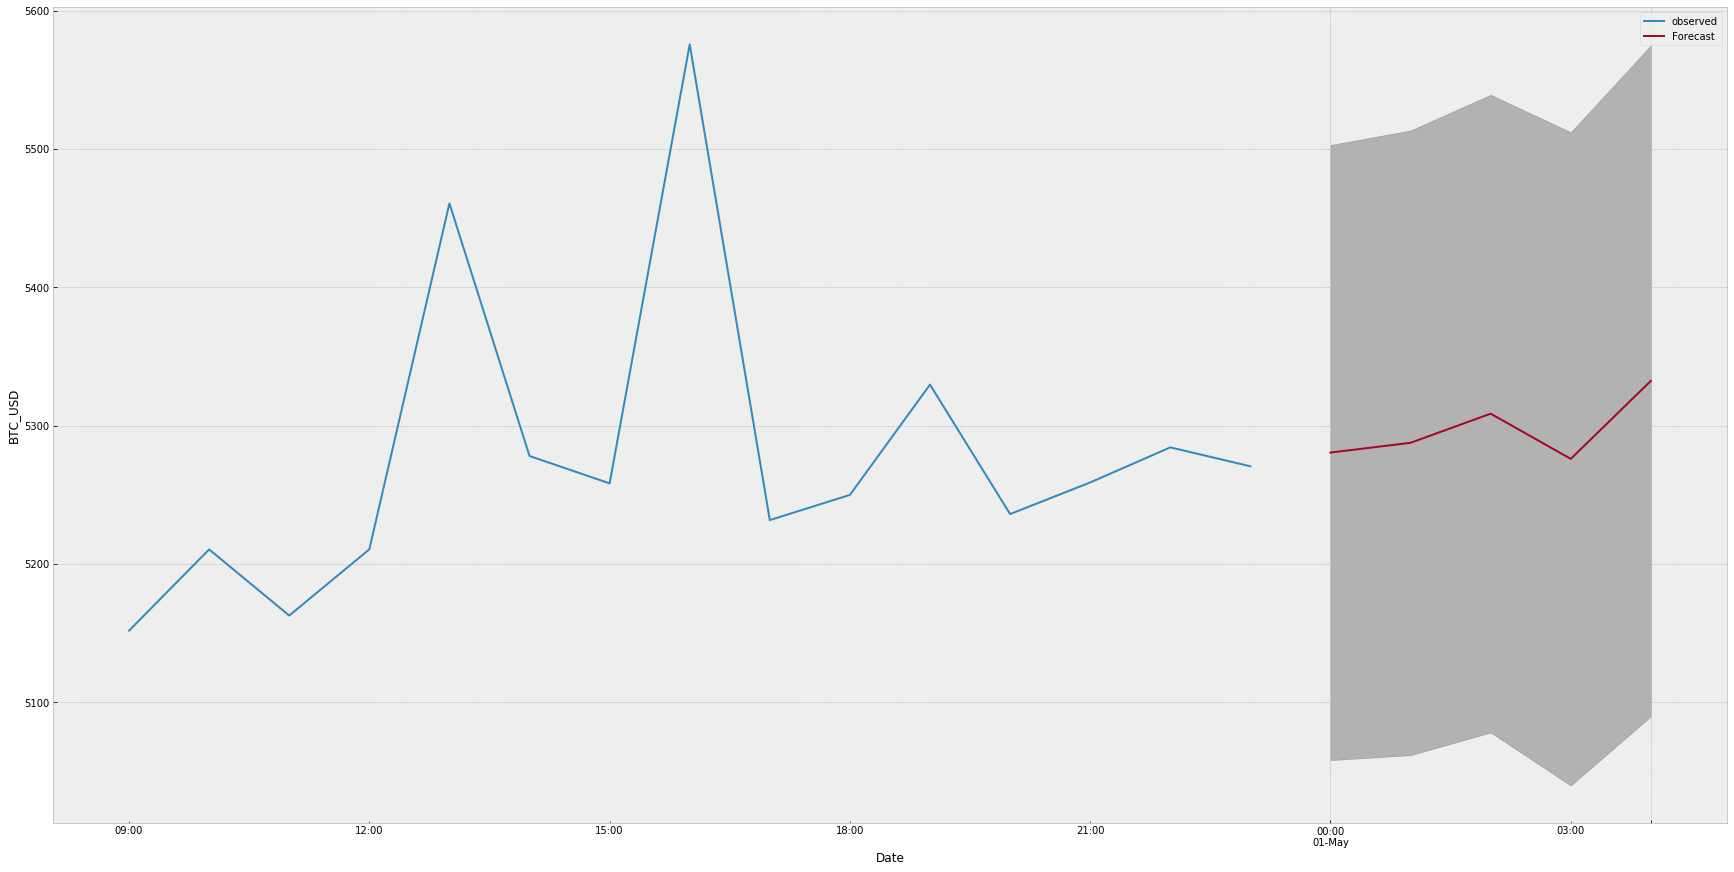

In [31]:
# Forcast the future
pred_uc = results.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()

ax = y[-15:].plot(label='observed', figsize=(30, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('BTC_USD')

plt.legend()

### Another one

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 2),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,
                                 enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])
print(results.aic)
dia = results.plot_diagnostics(figsize=(15, 12))

In [ ]:
pred = results.get_prediction(start=y.index[int(len(y)*0.8)], end=y.index[-1], dynamic=False)
pred_ci = pred.conf_int()

ax = y.plot(label='observed', figsize=(30, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('BTC-USD')
plt.legend()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y[int(len(y)*0.8):]
y_train = y[:int(len(y)*0.8)]

# MSE
mse = ((y_truth - y_forecasted) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

# OSR2
OSR2 = 1 - np.sum((y_truth - y_forecasted) ** 2)/np.sum((y_truth - np.average(y_truth)) ** 2)
print('The out-of-sample R2 of our model is {}'.format(round(OSR2, 4)))

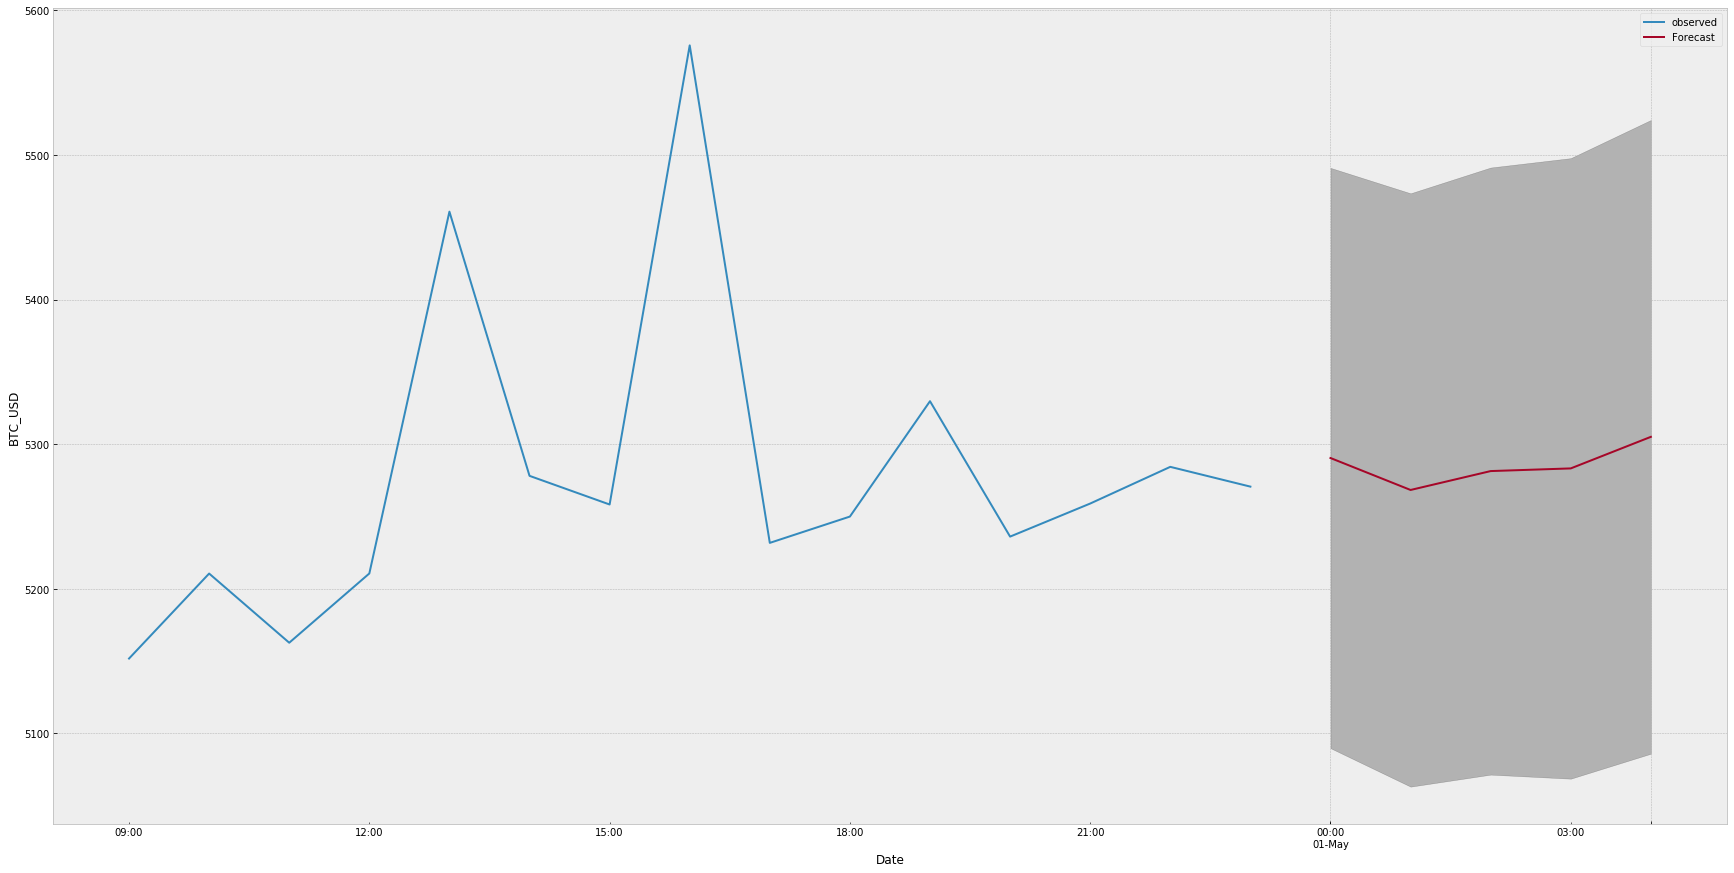

In [16]:
# Forcast the future
pred_uc = results.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()

ax = y[-15:].plot(label='observed', figsize=(30, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('BTC_USD')

plt.legend()

In [5]:
btc = pd.read_csv('../raw data/new/btc123.csv')

In [6]:
btc = btc[['time_period_start', 'price_close']]
btc['time_period_start'] = pd.to_datetime(btc['time_period_start'])
btc = btc.set_index('time_period_start')
btc = btc.resample('H').mean()
y2 = btc['price_close']

In [7]:
btc

,price_close
time_period_start,
2019-05-01 00:00:00,5309.321037
2019-05-01 01:00:00,5303.570000
2019-05-01 02:00:00,5326.200000
2019-05-01 03:00:00,5315.590000
2019-05-01 04:00:00,5319.274897
2019-05-01 05:00:00,5299.890000
2019-05-01 06:00:00,5285.437983
2019-05-01 07:00:00,5309.300000
2019-05-01 08:00:00,5294.760000


In [15]:
y = y.append(y2)

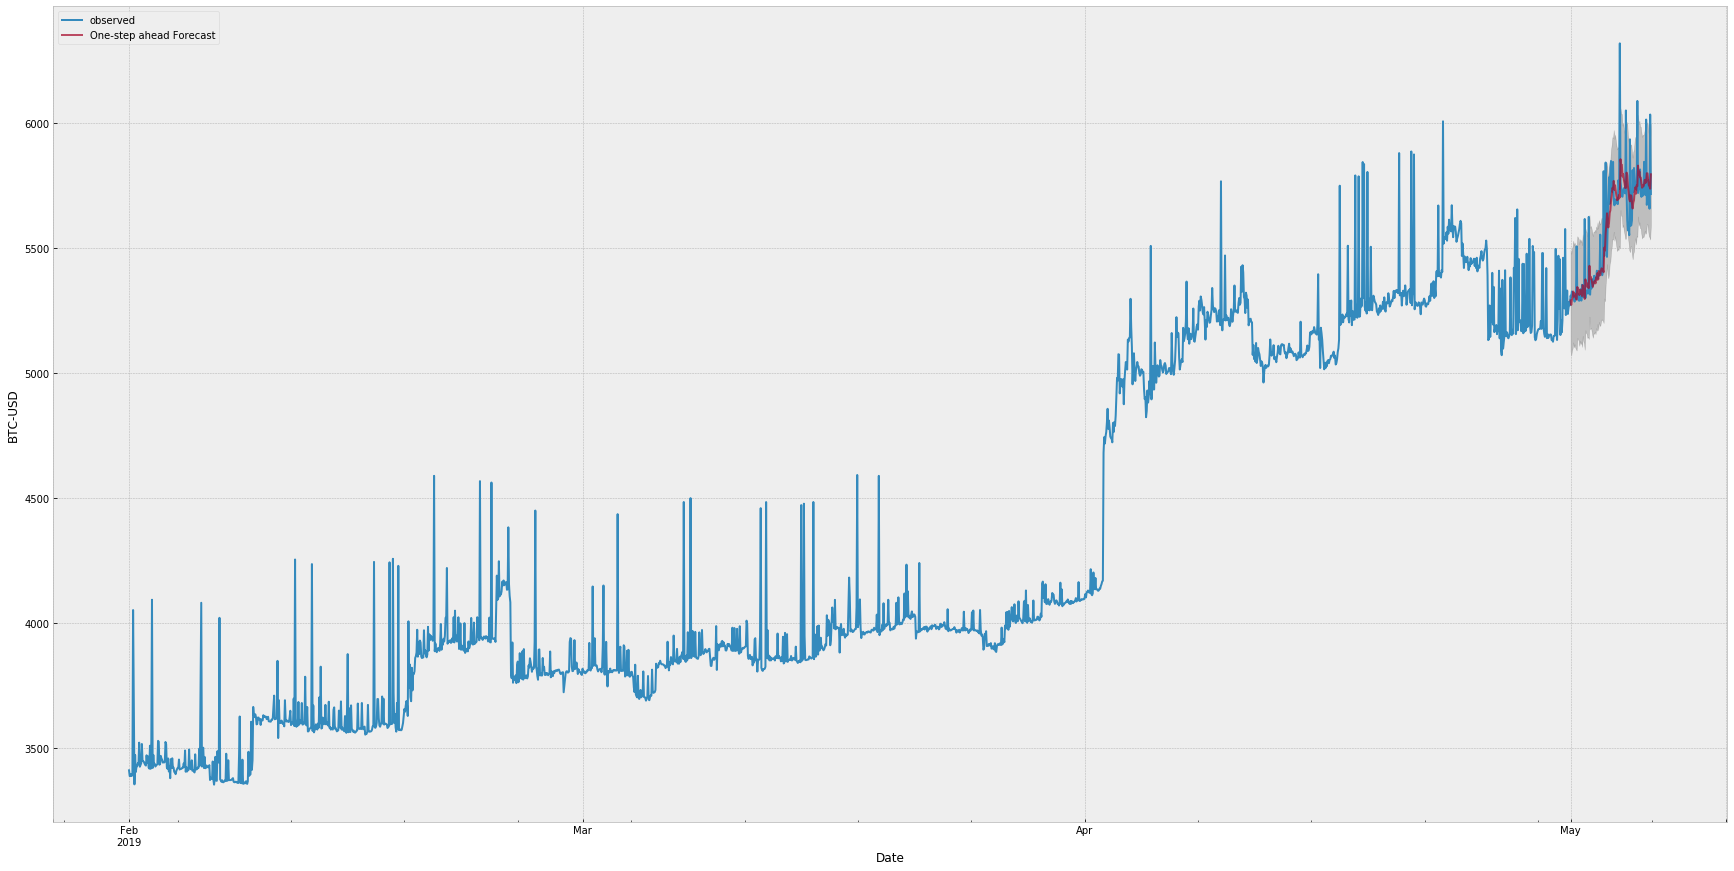

In [16]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 2),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,
                                 enforce_invertibility=False)
results = mod.fit()
pred = results.get_prediction(start=pd.to_datetime('2019-05-01 00:00:00'), end=y.index[-1], dynamic=False)
pred_ci = pred.conf_int()

ax = y.plot(label='observed', figsize=(30, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('BTC-USD')
plt.legend()

In [17]:
y_pred_ts = pred.predicted_mean

In [18]:
print(y['2019-05-01 00:00:00':].shape)
print(y_pred_ts.shape)

(120,)
(120,)


In [19]:
y_truth = y['2019-05-01 00:00:00':]
# MSE
mse = ((y_truth - y_pred_ts) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

# OSR2
OSR2 = 1 - np.sum((y_truth - y_pred_ts) ** 2)/np.sum((y_truth - np.average(y_truth)) ** 2)
print('The out-of-sample R2 of our model is {}'.format(round(OSR2, 4)))

The Mean Squared Error of our forecasts is 15655.8804
The out-of-sample R2 of our model is 0.6725


In [35]:
df = pd.DataFrame(y_pred_ts, columns=['predicted_ts'])

In [36]:
df = pd.merge(df,btc,left_index=True,right_index=True,how='outer')

In [37]:
df.head()

,predicted_ts,price_close
2019-05-01 00:00:00,5290.085208,5309.321037
2019-05-01 01:00:00,5272.309254,5303.570000
2019-05-01 02:00:00,5292.690253,5326.200000
2019-05-01 03:00:00,5301.989649,5315.590000
2019-05-01 04:00:00,5325.591318,5319.274897


In [38]:
df['roi_predicted_ts'] = np.log(df["predicted_ts"]/df["predicted_ts"].shift(1))
df['roi_truth'] = np.log(df["price_close"]/df["price_close"].shift(1))

In [41]:
from sklearn.preprocessing import StandardScaler
df = df.dropna()
for i in df.columns.tolist()[-2:]:
    df[i] = StandardScaler().fit_transform(df[i].values.reshape(-1, 1))

In [45]:
mse = ((df["roi_predicted_ts"] - df["roi_truth"]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 3.1311


In [22]:
df = pd.read_csv('ts.csv')

In [24]:
df['roi_predicted_ts'] = np.log(df["predicted_ts"]/df["price_close"].shift(1))
df['roi_truth'] = np.log(df["price_close"]/df["price_close"].shift(1))

In [26]:
from sklearn.preprocessing import StandardScaler
df = df.dropna()
for i in df.columns.tolist()[-2:]:
    df[i] = StandardScaler().fit_transform(df[i].values.reshape(-1, 1))

In [28]:
mse = ((df["roi_predicted_ts"] - df["roi_truth"]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.749


In [29]:
df.to_csv('ts.csv')